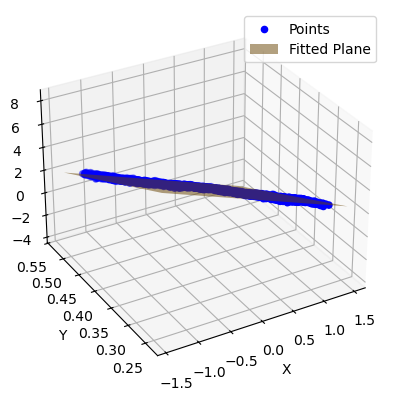

Average distance of points to the fitted plane: 0.0027


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def fit_plane_and_visualize(points):
    # Fit a plane using SVD
    centroid = points.mean(axis=0)
    points_centered = points - centroid
    _, _, vh = np.linalg.svd(points_centered)
    normal = vh[2, :]  # Normal vector of the plane

    # Equation of the plane: (x - cx) * nx + (y - cy) * ny + (z - cz) * nz = 0
    # Solve for z to visualize: z = (-nx * (x - cx) - ny * (y - cy)) / nz + cz
    d = -centroid.dot(normal)

    # Set up the plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='b', label='Points')

    # Create a grid to visualize the plane
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 10),
                         np.linspace(ylim[0], ylim[1], 10))
    zz = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]

    # Plot the plane
    ax.plot_surface(xx, yy, zz, color='orange', alpha=0.5, rstride=100, cstride=100, label='Fitted Plane')

    # Labeling and legend
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # rotate the 3d plot 
    ax.view_init(azim=-120)
    plt.legend(['Points', 'Fitted Plane'])
    plt.show()

    # Calculate and print the average distance to the plane
    distances = np.abs((points @ normal + d) / np.linalg.norm(normal))
    avg_distance = np.mean(distances)
    print(f"Average distance of points to the fitted plane: {avg_distance:.4f}")

# Example usage with random points
points = np.loadtxt('/Users/shrinivas/workspace/16-811/Assignment-3/clear_table.txt')  # Replace with your Nx3 array of points
fit_plane_and_visualize(points)

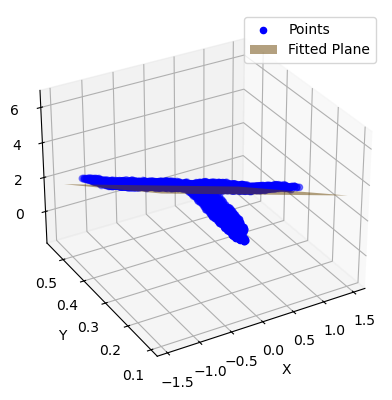

In [83]:
# Example usage with random points
points = np.loadtxt('/Users/shrinivas/workspace/16-811/Assignment-3/cluttered_table.txt')  # Replace with your Nx3 array of points
fit_plane_and_visualize(points)

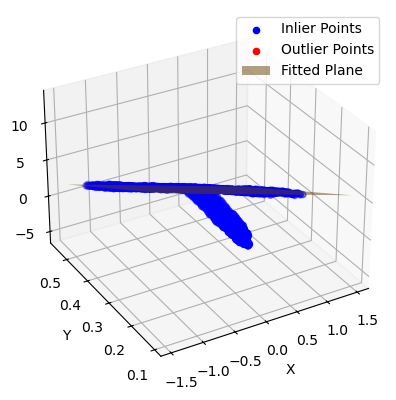

In [2]:
def fit_plane_and_visualize_ransac(points, threshold=0.1, max_iterations=100):
    def fit_plane(points):
        # Compute centroid
        centroid = points.mean(axis=0)
        # Center the points
        points_centered = points - centroid
        # Singular Value Decomposition (SVD)
        _, _, vh = np.linalg.svd(points_centered)
        # Plane normal is the third column of vh
        normal = vh[2, :]
        # Calculate d in the plane equation ax + by + cz + d = 0
        d = -centroid.dot(normal)
        return normal, d, centroid

    best_inliers = []
    best_normal = None
    best_d = None
    outliers = None
    # RANSAC iterations
    for _ in range(max_iterations):
        # Randomly sample 3 points to fit a plane
        sample_indices = np.random.choice(points.shape[0], 3, replace=False)
        sample_points = points[sample_indices]

        # Fit a plane to the sampled points
        normal, d, _ = fit_plane(sample_points)

        # Calculate distances of all points from the plane
        distances = np.abs((points @ normal + d) / np.linalg.norm(normal))

        # Find inliers
        inliers = points[distances < threshold]

        # Update the best model if the current one has more inliers
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_normal = normal
            best_d = d
            outliers = points[distances >= threshold]

    # Separate inliers and outliers
    inlier_set = set(map(tuple, best_inliers))

    # Visualize the results
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the inlier points
    ax.scatter(best_inliers[:, 0], best_inliers[:, 1], best_inliers[:, 2], color='b', label='Inlier Points')
    
    # Plot the outlier points
    ax.scatter(outliers[:, 0], outliers[:, 1], outliers[:, 2], color='r', label='Outlier Points')

    # Create a grid to visualize the plane
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 10),
                         np.linspace(ylim[0], ylim[1], 10))
    zz = (-best_normal[0] * xx - best_normal[1] * yy - best_d) / best_normal[2]

    # Plot the plane
    ax.plot_surface(xx, yy, zz, color='orange', alpha=0.5, rstride=100, cstride=100)

    # Labeling and legend
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(azim=-120)
    plt.legend(['Inlier Points', 'Outlier Points', 'Fitted Plane'])
    plt.show()

# Example usage with random points and some outliers
points = np.loadtxt('/Users/shrinivas/workspace/16-811/Assignment-3/cluttered_table.txt')  # Replace with your Nx3 array of points

fit_plane_and_visualize_ransac(points, threshold=0.5)



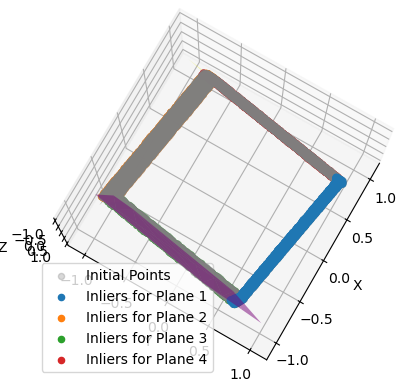

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def fit_plane(points):
    centroid = points.mean(axis=0)
    points_centered = points - centroid
    _, _, vh = np.linalg.svd(points_centered)
    normal = vh[2, :]
    d = -centroid.dot(normal)
    return normal, d, centroid

def select_close_points(points, proximity_threshold=0.1):
    random_idx = np.random.randint(points.shape[0])
    random_point = points[random_idx]
    distances = np.linalg.norm(points - random_point, axis=1)
    close_indices = np.where(distances < proximity_threshold)[0]
    
    while len(close_indices) < 10:
        proximity_threshold *= 1.5
        close_indices = np.where(distances < proximity_threshold)[0]
        
    close_indices = close_indices[:10]
    return points[close_indices]

def ransac_for_best_plane(points, max_iterations=1000, threshold=0.1):
    best_inliers = []
    best_normal = None
    best_d = None
    
    for _ in range(max_iterations):
        sample_points = select_close_points(points)
        normal, d, _ = fit_plane(sample_points)
        distances = np.abs((points @ normal + d) / np.linalg.norm(normal))
        inliers = points[distances < threshold]
        
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_normal = normal
            best_d = d
            
    return best_inliers, best_normal, best_d

def fit_plane_and_visualize_ransac_multiple_planes(points, num_planes=4, threshold=0.1, max_iterations=1000):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plane_colors = ['orange', 'green', 'purple', 'yellow']
    
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_zlim(-1.2, 1.2)
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='grey', alpha=0.3, label='Initial Points')
    
    points_ = points.copy()
    for i in range(num_planes):
        best_inliers, best_normal, best_d = ransac_for_best_plane(points_, max_iterations, threshold)
        best_normal, best_d, _ = fit_plane(best_inliers)
        ax.scatter(best_inliers[:, 0], best_inliers[:, 1], best_inliers[:, 2], label=f'Inliers for Plane {i+1}')
        
        xx, yy = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10))
        zz = (-best_normal[0] * xx - best_normal[1] * yy - best_d) / best_normal[2]
        
        mask = zz**2 <= 1
        xx, yy, zz = xx[mask], yy[mask], zz[mask]
        
        # Ensure we have enough points to plot a surface
        if len(xx) >= 3 and len(yy) >= 3 and len(zz) >= 3:
            ax.plot_trisurf(xx, yy, zz, color=plane_colors[i % len(plane_colors)], alpha=0.5)
        
        points_ = points_[~np.isin(points_, best_inliers).all(axis=1)]

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(azim=-30, elev=260)
    plt.legend()
    plt.show()

points = np.loadtxt('/Users/shrinivas/workspace/16-811/Assignment-3/clean_hallway.txt')
points = points - points.mean(axis=0)
points[:, 0] /= np.abs(points[:, 0]).max()
points[:, 1] /= np.abs(points[:, 1]).max()
points[:, 2] /= np.abs(points[:, 2]).max()

fit_plane_and_visualize_ransac_multiple_planes(points, num_planes=4, threshold=0.03)

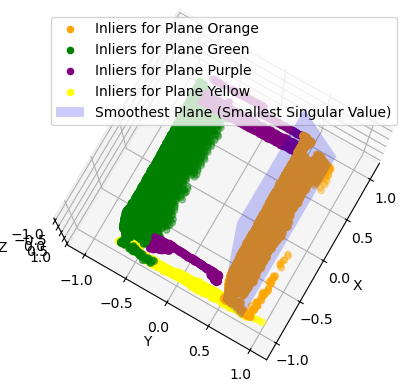

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def fit_plane(points):
    centroid = points.mean(axis=0)
    points_centered = points - centroid
    _, s, vh = np.linalg.svd(points_centered)
    normal = vh[2, :]
    d = -centroid.dot(normal)
    return normal, d, centroid, s[2]

def select_close_points(points, proximity_threshold=0.1):
    random_idx = np.random.randint(points.shape[0])
    random_point = points[random_idx]
    distances = np.linalg.norm(points - random_point, axis=1)
    close_indices = np.where(distances < proximity_threshold)[0]
    
    while len(close_indices) < 10:
        proximity_threshold *= 1.5
        close_indices = np.where(distances < proximity_threshold)[0]
        
    close_indices = close_indices[:10]
    return points[close_indices]

def ransac_for_best_plane(points, max_iterations=1000, threshold=0.1):
    best_inliers = []
    best_normal = None
    best_d = None
    best_singular_value = None
    
    for _ in range(max_iterations):
        sample_points = select_close_points(points)
        normal, d, _, third_singular_value = fit_plane(sample_points)
        distances = np.abs((points @ normal + d) / np.linalg.norm(normal))
        inliers = points[distances < threshold]
        
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_normal = normal
            best_d = d
            best_singular_value = third_singular_value
            
    return best_inliers, best_normal, best_d, best_singular_value

def fit_plane_and_visualize_ransac_multiple_planes(points, num_planes=4, threshold=0.1, max_iterations=1000):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plane_colors = ['orange', 'green', 'purple', 'yellow']
    
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_zlim(-1.2, 1.2)
    
    smallest_singular_value = np.inf
    smallest_inliers = None
    smallest_normal = None
    smallest_d = None
    all_inliers = []

    points_ = points.copy()
    for i in range(num_planes):
        best_inliers, best_normal, best_d, best_singular_value = ransac_for_best_plane(points_, max_iterations, threshold)
        
        # Track the plane with the smallest third singular value
        if best_singular_value < smallest_singular_value:
            smallest_singular_value = best_singular_value
            smallest_inliers = best_inliers
            smallest_normal = best_normal
            smallest_d = best_d

        # Store the inliers for all planes for plotting
        all_inliers.append((best_inliers, plane_colors[i % len(plane_colors)]))
        
        # Update points to exclude inliers found for this plane
        points_ = points_[~np.isin(points_, best_inliers).all(axis=1)]

    # Plot the inliers for each plane
    for inliers, color in all_inliers:
        ax.scatter(inliers[:, 0], inliers[:, 1], inliers[:, 2], color=color, label=f'Inliers for Plane {color.capitalize()}')
    
    # Plot the smoothest plane with the smallest singular value
    if smallest_inliers is not None:
        xx, yy = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10))
        zz = (-smallest_normal[0] * xx - smallest_normal[1] * yy - smallest_d) / smallest_normal[2]
        
        mask = zz**2 <= 1
        xx, yy, zz = xx[mask], yy[mask], zz[mask]
        
        # Plot the surface for the smoothest plane
        if len(xx) >= 3 and len(yy) >= 3 and len(zz) >= 3:
            ax.plot_trisurf(xx.ravel(), yy.ravel(), zz.ravel(), color='blue', alpha=0.2, label='Smoothest Plane (Smallest Singular Value)')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(azim=-30, elev=260)
    plt.legend()
    plt.show()

# Load and normalize point data
points = np.loadtxt('/Users/shrinivas/workspace/16-811/Assignment-3/cluttered_hallway.txt')
points = points - points.mean(axis=0)
points[:, 0] /= np.abs(points[:, 0]).max()
points[:, 1] /= np.abs(points[:, 1]).max()
points[:, 2] /= np.abs(points[:, 2]).max()

fit_plane_and_visualize_ransac_multiple_planes(points, num_planes=4, threshold=0.03)